In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch

if torch.cuda.is_available():
    print("✅ CUDA is available! Running on GPU:", torch.cuda.get_device_name(0))
else:
    print("❌ CUDA is not available. Running on CPU.")

✅ CUDA is available! Running on GPU: NVIDIA A100-SXM4-40GB


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.1 MB/s eta 0:00:00


## XGBoost + Logistic Regression Stacking + Optuna + K-Fold (5-Fold)

0. 데이터 처리

✅ 결측치 처리

✅ 라벨 인코딩(Label Encoding)

✅ 훈련 데이터와 검증 데이터 분할


1. XGBoost + Logistic Regression Stacking 적용

✅ XGBoost가 예측한 확률값을 Logistic Regression의 입력으로 사용

✅ XGBoost 단일 모델의 강력한 예측력을 활용하면서, 로지스틱 회귀로 성능 향상

2. Optuna를 활용한 하이퍼파라미터 최적화

✅ n_estimators, learning_rate, max_depth 등 XGBoost의 핵심 하이퍼파라미터 자동 최적화

✅ 최적의 하이퍼파라미터로 XGBoost 학습 성능 극대화

3. K-Fold Cross Validation 적용

✅ K-Fold(5-Fold) 적용하여 일반화 성능 향상

✅ 데이터를 5개 Fold로 나누어 XGBoost 모델이 더 잘 학습하도록 함
  

  
    ### XGBoost 학습 (Optuna 하이퍼파라미터 최적화)
    
    ✅ Optuna를 사용한 하이퍼파라미터 튜닝
    
    - `objective()` 함수 내에서 Optuna를 활용해 **최적의 하이퍼파라미터**를 탐색
    - 학습 속도(`learning_rate`), 트리 깊이(`max_depth`), 부트스트랩(`subsample`), 정규화(`reg_lambda`, `reg_alpha`) 등을 조정
    - 5-Fold Cross Validation을 수행하여 최적의 모델을 찾음
    
    ✅ 최적의 하이퍼파라미터를 찾은 후 모델 학습
    
    - `best_params_xgb`를 사용하여 최적의 XGBoost 모델을 생성하고, 훈련 데이터에서 학습 진행
    
    
    ### K-Fold Cross Validation을 활용한 XGBoost 예측
    
    ✅5-Fold Cross Validation을 사용하여 학습 진행
    
    - `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`를 사용하여 데이터셋을 5개의 Fold로 나눔
    - XGBoost 모델을 각 Fold에 대해 학습 후 검증 데이터를 예측
    - 각 Fold에서 나온 예측 확률을 저장하고, 평균을 내어 최종적인 확률값을 생성
    
    ✅ XGBoost 예측값 저장
    
    - `xgb_train_meta[val_idx] = clf.predict_proba(X_v)[:, 1]` → 검증 데이터 확률값 저장
    - `xgb_val_meta += clf.predict_proba(X_val)[:, 1] / kf.n_splits` → 검증 데이터 예측값 저장
    - `xgb_test_meta += clf.predict_proba(X_test)[:, 1] / kf.n_splits` → 테스트 데이터 예측값 저장
    
    
    ### Logistic Regression Stacking
    
    ✅ Logistic Regression을 활용한 Stacking
    
    - XGBoost에서 나온 검증 데이터의 예측 확률값을 Logistic Regression의 입력값으로 사용
    - Logistic Regression은 XGBoost보다 해석 가능성이 높고, 과적합을 줄이는 효과가 있음
    - `log_reg.fit(X_train_meta, y_train)` → XGBoost의 예측값을 Logistic Regression 모델의 훈련 데이터로 활용
    
    ✅ 검증 데이터에서 최종 예측 수행
    
    - `y_val_pred_logreg = log_reg.predict(X_val_meta)`
    - `confusion_matrix(y_val, y_val_pred_logreg)`을 사용하여 검증 데이터의 성능을 평가

In [46]:
import gc
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

#############################
# 1) 데이터 불러오기
#############################
train_transaction = pd.read_csv("/content/drive/MyDrive/ITStudy/data/train_transaction.csv")
train_identity = pd.read_csv("/content/drive/MyDrive/ITStudy/data/train_identity.csv")
test_transaction = pd.read_csv('/content/drive/MyDrive/ITStudy/data/test_transaction.csv')
test_identity = pd.read_csv('/content/drive/MyDrive/ITStudy/data/test_identity.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/ITStudy/data/sample_submission.csv')

#############################
# 2) 컬럼명 치환 ( '-' → '_' )
#############################
for df in [train_transaction, train_identity, test_transaction, test_identity]:
    df.columns = [c.replace('-', '_') for c in df.columns]

#############################
# 3) Train 병합, Test 병합
#############################
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test  = test_transaction.merge(test_identity,   how='left', left_index=True, right_index=True)
del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

#############################
# 4) 타깃 분리
#############################
y_all = train['isFraud'].copy()
X_all = train.drop('isFraud', axis=1)
X_test = test.copy()
del train, test
gc.collect()

#############################
# 5) 결측치 처리
#############################
X_all  = X_all.fillna(-999)
X_test = X_test.fillna(-999)

#############################
# 6) 라벨 인코딩
#############################
for col in X_all.columns:
    if X_all[col].dtype == 'object' or X_test[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(X_all[col].values) + list(X_test[col].values))
        X_all[col]  = le.transform(X_all[col].values)
        X_test[col] = le.transform(X_test[col].values)

#############################
# 7) Train/Validation 분할
#############################
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

#############################
# 8) Optuna를 활용한 XGBoost 하이퍼파라미터 최적화
#############################
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
        'tree_method': 'gpu_hist',  # ✅ GPU 사용
        'predictor': 'gpu_predictor'
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params, eval_metric="logloss")
        model.fit(X_tr, y_tr)

        preds = model.predict(X_v)
        score = accuracy_score(y_v, preds)
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params_xgb = study.best_params
best_params_xgb.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})

#############################
# 9) K-Fold를 이용한 XGBoost 학습 & 예측 저장
#############################
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_train_meta = np.zeros(X_train.shape[0])  # 검증 데이터 예측 확률값 저장
xgb_val_meta = np.zeros(X_val.shape[0])  # 검증 데이터 예측 확률값 저장
xgb_test_meta = np.zeros(X_test.shape[0])  # 테스트 데이터 예측 확률값 저장

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\n📌 Fold {fold+1}: Training...")

    X_tr, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

    clf = xgb.XGBClassifier(**best_params_xgb, eval_metric="logloss")
    clf.fit(X_tr, y_tr)

    # 검증 데이터 예측 확률값 저장
    xgb_train_meta[val_idx] = clf.predict_proba(X_v)[:, 1]
    xgb_val_meta += clf.predict_proba(X_val)[:, 1] / kf.n_splits  # ✅ 검증 데이터 확률값 저장
    xgb_test_meta += clf.predict_proba(X_test)[:, 1] / kf.n_splits  # ✅ 테스트 데이터 확률값 저장

#############################
# 10) Logistic Regression Stacking 적용
#############################
X_train_meta = xgb_train_meta.reshape(-1, 1)
X_val_meta = xgb_val_meta.reshape(-1, 1)  # ✅ 검증 데이터 확률값 사용
X_test_meta = xgb_test_meta.reshape(-1, 1)

log_reg = LogisticRegression(C=0.5)
log_reg.fit(X_train_meta, y_train)

# ✅ 검증 데이터에서 예측
y_val_pred_logreg = log_reg.predict(X_val_meta)  # ✅ 검증 데이터 예측 수행

# ✅ 검증 데이터의 혼동 행렬 출력
cm_logreg = confusion_matrix(y_val, y_val_pred_logreg)
print("\n📌 Logistic Regression Stacking Performance (Validation Data Only):")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_logreg) * 100:.2f}%")
print("Confusion Matrix:")
print(cm_logreg)
print(classification_report(y_val, y_val_pred_logreg))

#############################
# 11) 최종 예측 (테스트 데이터)
#############################
test_pred_final = log_reg.predict_proba(X_test_meta)[:, 1]

sample_submission['isFraud'] = test_pred_final
sample_submission.to_csv('xgb_logreg_gpu_optuna_kfold.csv', index=False)
print("✅ Done! Predictions saved to 'xgb_logreg_gpu_optuna_kfold.csv'")


[I 2025-03-13 05:06:42,703] A new study created in memory with name: no-name-dced226d-8a80-4db8-8353-887e98ba07ca
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:06:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:06:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:06:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local


📌 Fold 1: Training...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:19:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:19:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:19:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



📌 Fold 2: Training...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:19:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:19:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:19:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



📌 Fold 3: Training...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



📌 Fold 4: Training...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



📌 Fold 5: Training...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



📌 Logistic Regression Stacking Performance (Validation Data Only):
Accuracy: 98.70%
Confusion Matrix:
[[113856    119]
 [  1420   2713]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.96      0.66      0.78      4133

    accuracy                           0.99    118108
   macro avg       0.97      0.83      0.89    118108
weighted avg       0.99      0.99      0.99    118108

✅ Done! Predictions saved to 'xgb_logreg_gpu_optuna_kfold.csv'


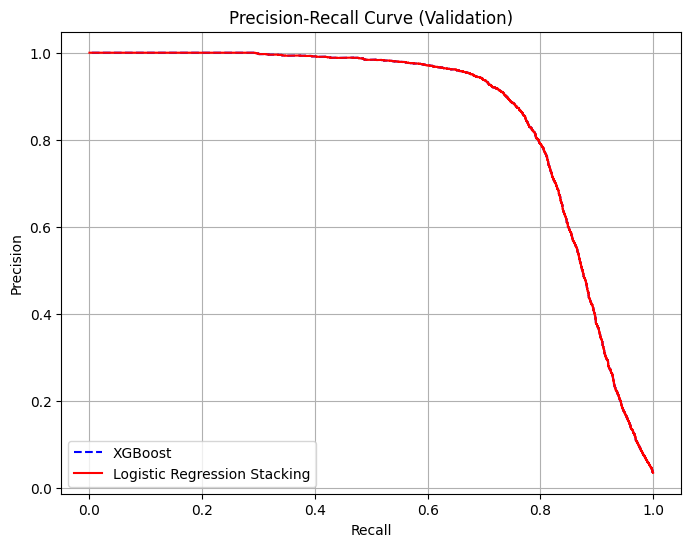

In [50]:
# ✅ 검증 데이터에서 예측 확률값 추출
y_val_proba_logreg = log_reg.predict_proba(X_val_meta)[:, 1]

# ✅ Precision-Recall Curve 출력
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, xgb_val_meta)
precision_logreg, recall_logreg, _ = precision_recall_curve(y_val, y_val_proba_logreg)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, label="XGBoost", linestyle="--", color="blue")
plt.plot(recall_logreg, precision_logreg, label="Logistic Regression Stacking", linestyle="-", color="red")
plt.title("Precision-Recall Curve (Validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

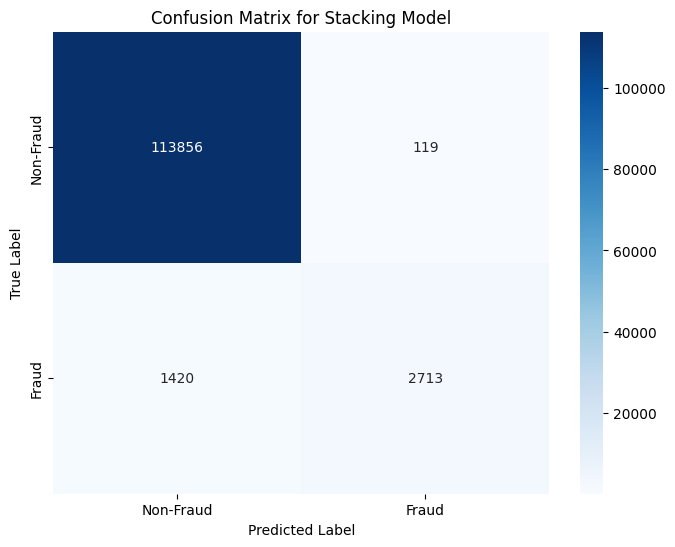

In [53]:
# ✅ 15. 혼동 행렬 시각화
cm = confusion_matrix(y_val, y_val_pred_logreg)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stacking Model')
plt.show()